In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import astropy
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
import hdbscan
from astropy.io import fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
GrID = pd.read_csv('rcsed_iGrID.csv')
NANfilter = pd.notna(GrID.iGrID)
y = GrID[NANfilter]
DATA = pd.read_csv('real_data.csv', index_col='Unnamed: 0')
x = DATA[NANfilter]

C:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
x.shape

(401148, 559)

In [17]:
np.sum(x.isna().sum() < 50000)

145

In [18]:
x = x.drop(x.columns[x.isna().any().values].values, axis=1)

In [19]:
x.shape

(401148, 112)

In [21]:
x = x.select_dtypes(include='number')

In [28]:
for c in x.columns:
    print(c, '-', x[c].unique().size)

ind - 401148
ra - 396689
dec - 400249
z_sdss - 383307
specObjID_sdss - 401148
bestObjID_sdss - 401136
plate_sdss - 4163
mjd_sdss - 1488
fiberID_sdss - 1000
q_z_2df - 7
quality_6df - 6
specid_6df - 3508
recno_uzc - 9514
obsid_lamost - 66762
lmjd_lamost - 595
mjd_lamost - 595
spid_lamost - 17
fiberid_lamost - 251
f_z_lega_c - 1
f_spec_lega_c - 1
OBJNO_deep2 - 9
OBJNO_deep3 - 4
Q_wigglez - 4
NQ_gama - 6
multiple_z - 2
dz - 2
E_bv - 397822
A_u_sdss - 397822
A_g_sdss - 397822
A_r_sdss - 397822
A_i_sdss - 397822
A_z_sdss - 397822
A_g_des - 397822
A_r_des - 397822
A_i_des - 397822
A_z_des - 397822
A_u_skymapper - 397822
A_v_skymapper - 397822
A_g_skymapper - 397822
A_r_skymapper - 397822
A_i_skymapper - 397822
A_z_skymapper - 397822
A_Y_ukidss - 397822
A_J_ukidss - 397822
A_H_ukidss - 397822
A_K_ukidss - 397822
A_Z_viking - 397822
A_Y_viking - 397822
A_J_viking - 397822
A_H_viking - 397822
A_ks_viking - 397822
A_g_panstarrs - 397822
A_r_panstarrs - 397822
A_i_pansatrrs - 397822
A_z_panstarrs 

In [29]:
x = x.drop(['ind', 'spid_lamost', 'z_err', 'specObjID_sdss', 'z_sdss', 'f_spec_lega_c', 'f_z_lega_c', 'phot_data_new_galex', 'bestObjID_sdss', 'specid_6df', 'q_z_2df', 'recno_uzc', 'OBJNO_deep2', 'OBJNO_deep3', 'obsid_lamost', 'lmjd_lamost', 'mjd_lamost', 'quality_6df', 'Q_wigglez', 'NQ_gama', 'fibermag_i_sdss', 'fibermag_z_sdss', 'fibermagerr_i_sdss', 'fibermagerr_z_sdss', 'fiber2mag_i_sdss', 'fiber2mag_z_sdss', 'fiber2magerr_i_sdss', 'fiber2magerr_z_sdss', 'petromag_i_sdss', 'petromag_z_sdss', 'petromagerr_i_sdss', 'petromagerr_z_sdss', 'petror50_u_sdss', 'petror50_g_sdss', 'petror50_r_sdss', 'petror50_i_sdss', 'petror50_z_sdss' , 'multiple_z', 'dz', 'wigglez_photo'], axis=1)

In [30]:
x.shape

(401148, 66)

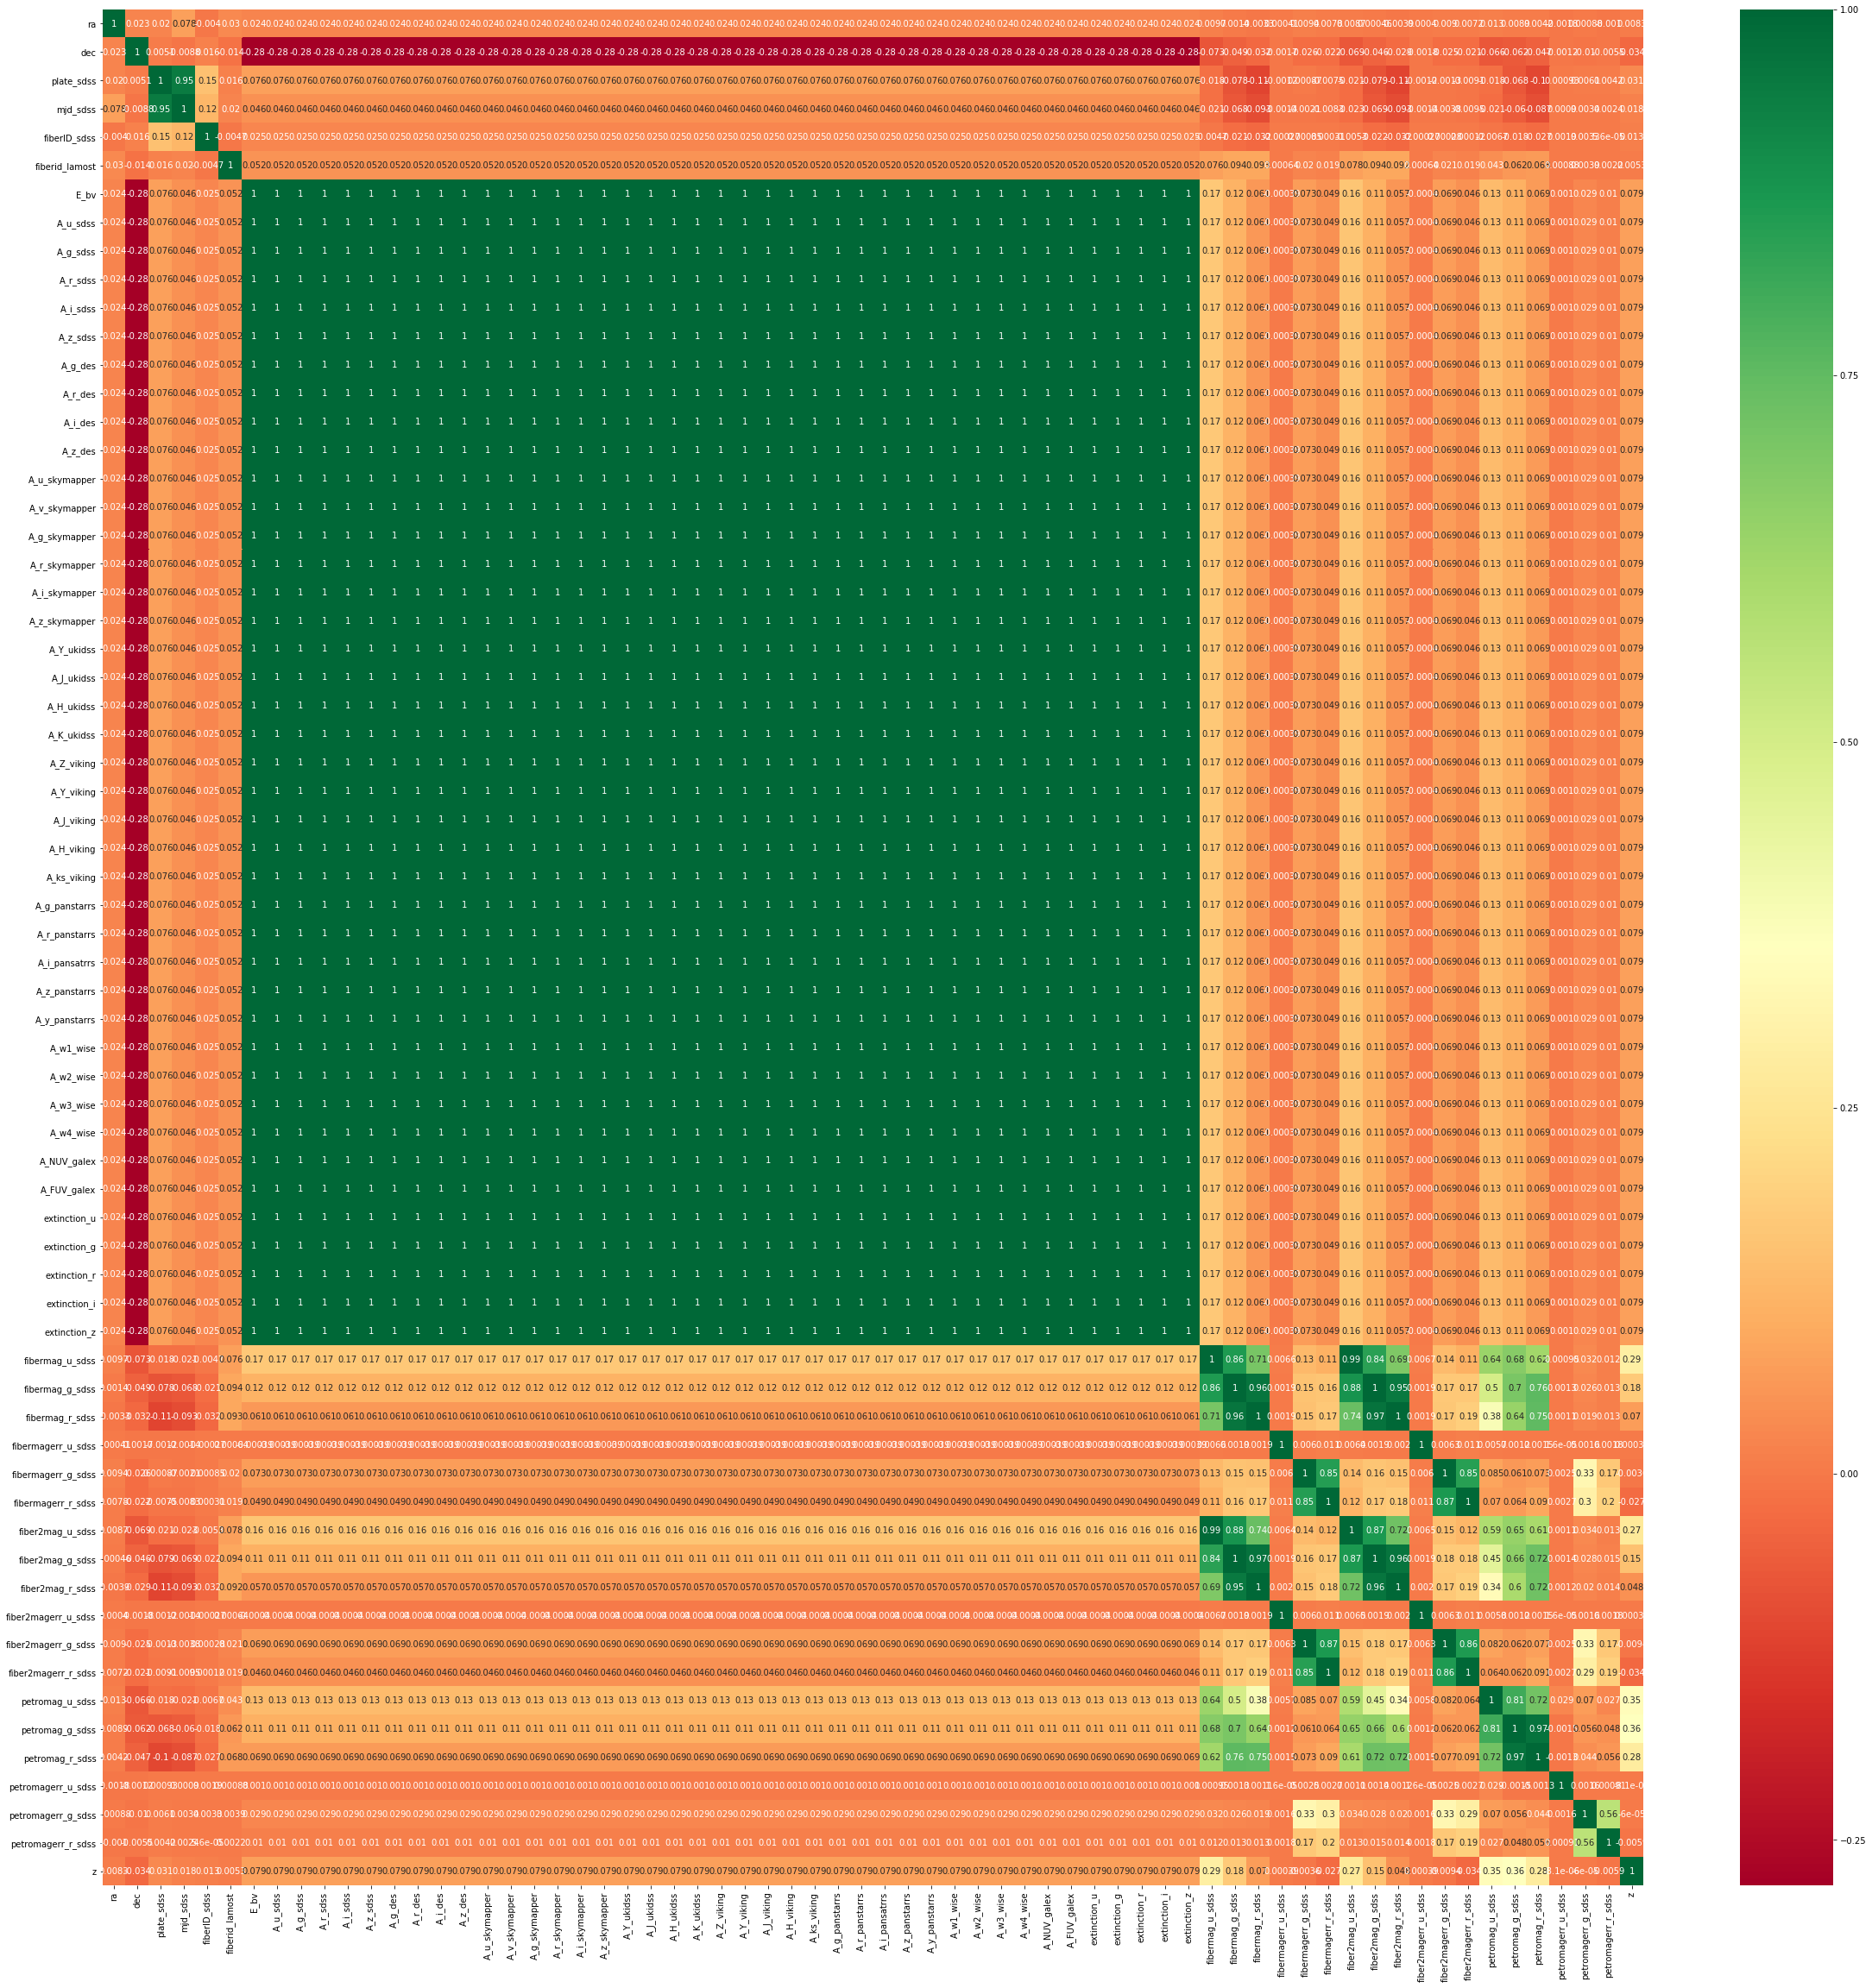

In [33]:
corrmat = x.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40,40))
g=sns.heatmap(x[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.savefig('corr.png')

In [34]:
x.describe()

,ra,dec,plate_sdss,mjd_sdss,fiberID_sdss,fiberid_lamost,E_bv,A_u_sdss,A_g_sdss,A_r_sdss,...,fiber2magerr_u_sdss,fiber2magerr_g_sdss,fiber2magerr_r_sdss,petromag_u_sdss,petromag_g_sdss,petromag_r_sdss,petromagerr_u_sdss,petromagerr_g_sdss,petromagerr_r_sdss,z
count,401148.000000,401148.000000,401148.000000,401148.000000,401148.000000,401148.00000,401148.000000,401148.000000,401148.000000,401148.000000,...,4.011480e+05,401148.000000,401148.000000,401148.000000,401148.000000,401148.000000,401148.000000,401148.000000,401148.000000,401148.000000
mean,185.007935,23.807908,1651.313520,53216.810432,329.925673,233.49045,0.033912,0.143751,0.112010,0.077488,...,6.615896e+02,0.019103,0.016305,19.052106,17.521305,16.813103,0.465334,0.026614,0.025405,0.068930
std,66.823551,18.808789,1144.254751,1023.632592,193.940920,56.11298,0.030815,0.130625,0.101782,0.070412,...,3.962909e+05,0.039273,0.037872,1.061570,0.868288,0.876982,131.743216,0.164878,0.274220,0.034703
min,0.004283,-11.244275,266.000000,51578.000000,1.000000,1.00000,0.003033,0.012855,0.010017,0.006929,...,4.855000e-03,0.001637,0.001200,12.228400,11.245700,10.482300,0.003065,0.001012,0.000741,0.001646
25%,150.263920,8.322114,845.000000,52378.000000,165.000000,255.00000,0.018737,0.079426,0.061888,0.042814,...,5.844300e-02,0.009346,0.006797,18.508700,17.092900,16.360100,0.063137,0.010317,0.008761,0.050161
50%,186.631720,22.059346,1495.000000,53089.000000,327.000000,255.00000,0.027885,0.118203,0.092103,0.063716,...,8.502400e-02,0.012825,0.009727,19.106900,17.689500,16.989200,0.094700,0.014369,0.012319,0.072143
75%,224.167302,37.636392,2143.000000,53826.000000,489.000000,255.00000,0.041379,0.175406,0.136675,0.094551,...,1.193522e-01,0.018050,0.014717,19.653200,18.135100,17.473400,0.139950,0.020862,0.018497,0.088644
max,359.997360,70.266548,8873.000000,57511.000000,1000.000000,255.00000,1.921652,8.145884,6.347217,4.390975,...,2.508880e+08,1.966780,1.988020,41.270800,31.917600,29.380400,82332.400000,69.366300,114.651000,6.655937


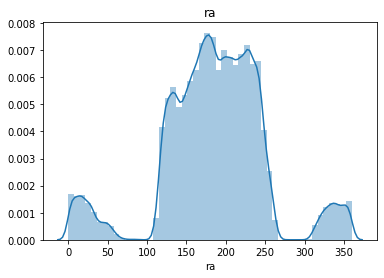

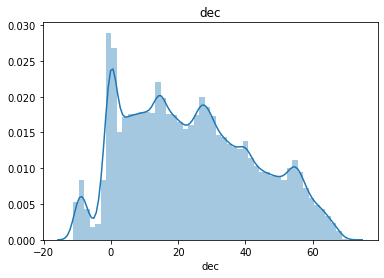

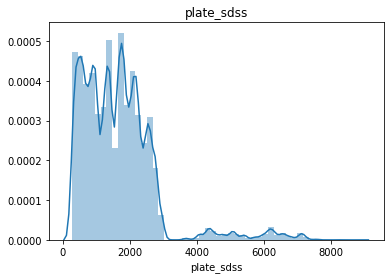

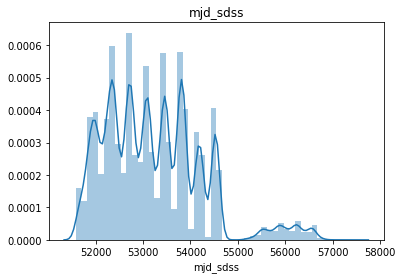

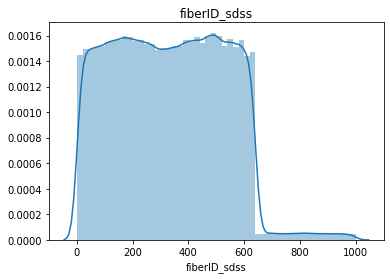

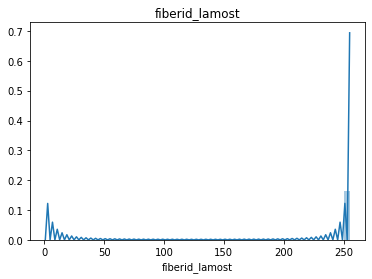

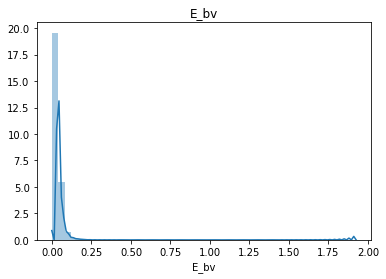

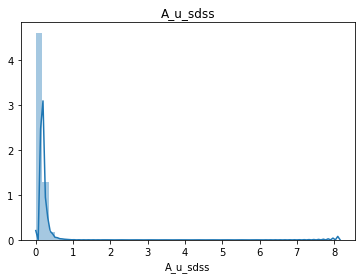

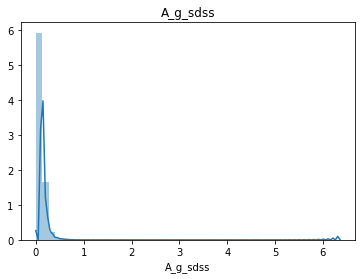

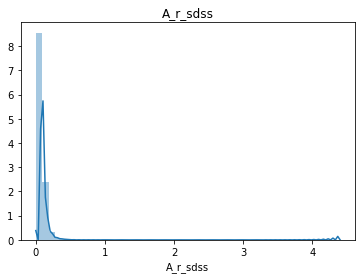

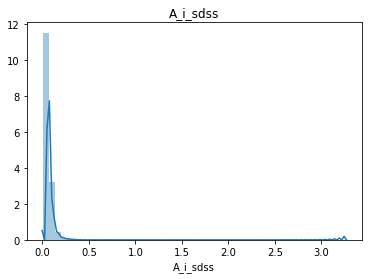

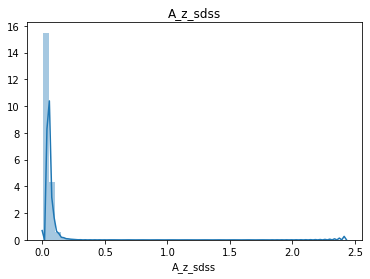

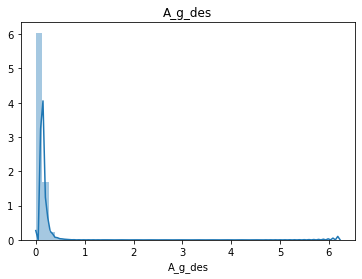

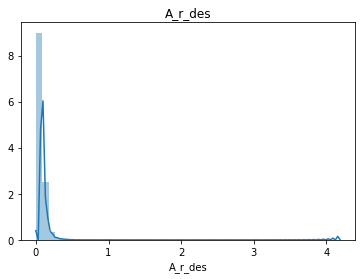

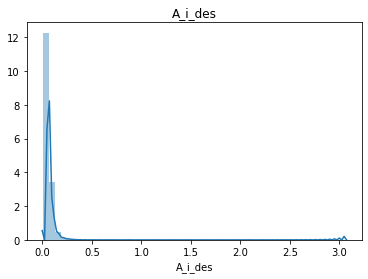

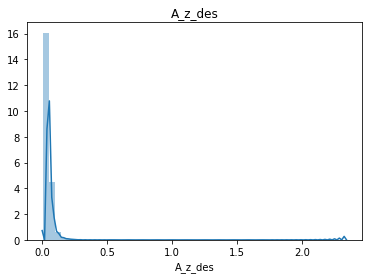

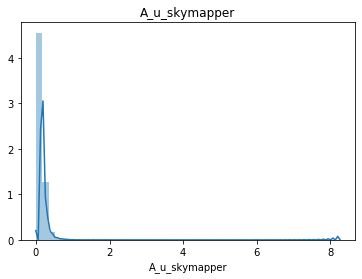

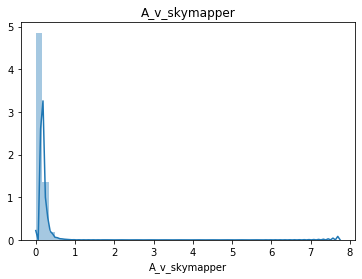

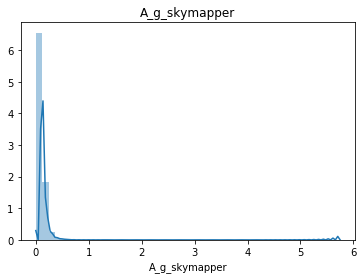

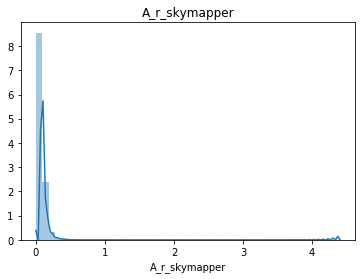

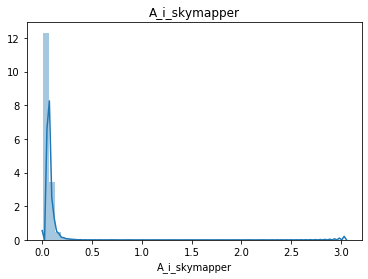

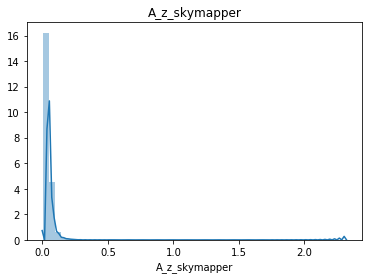

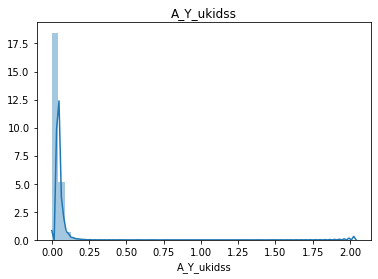

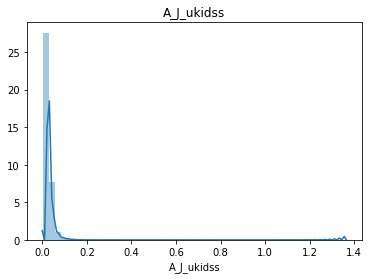

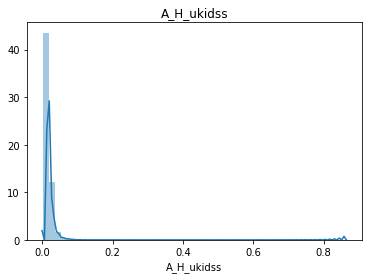

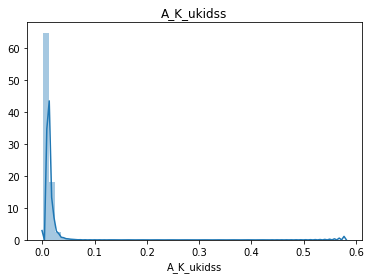

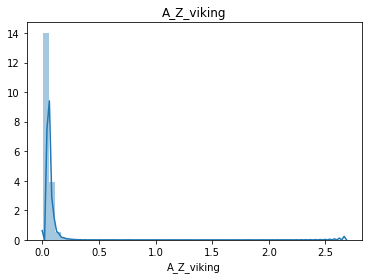

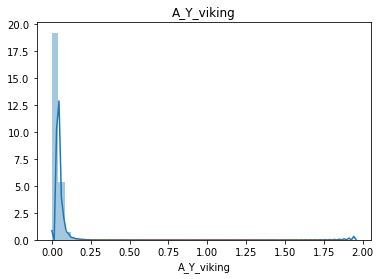

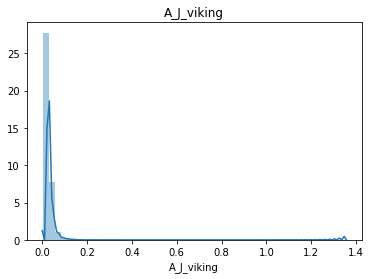

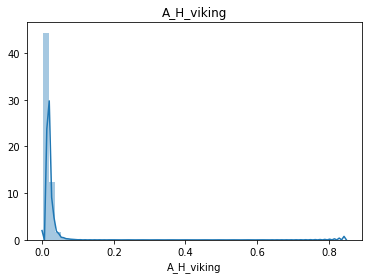

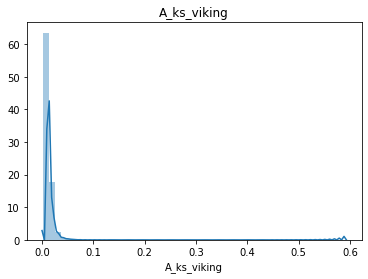

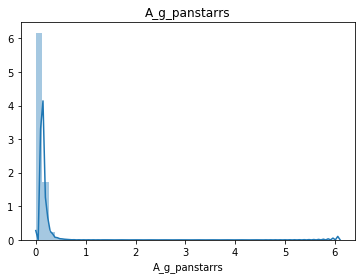

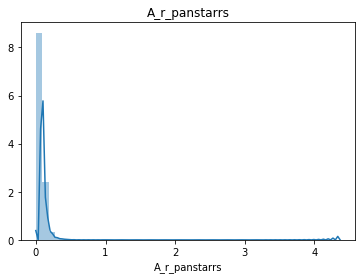

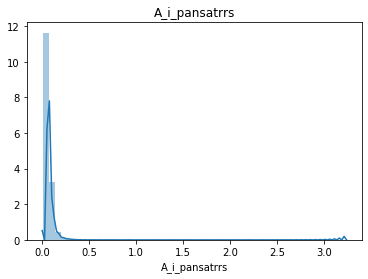

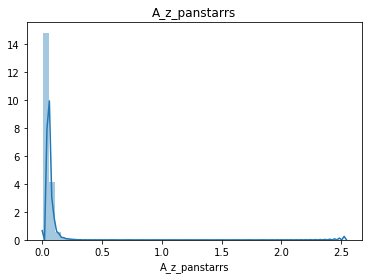

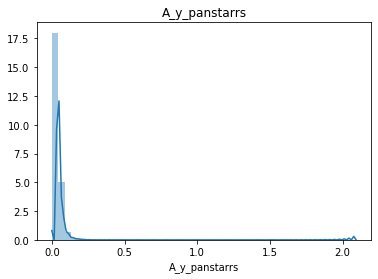

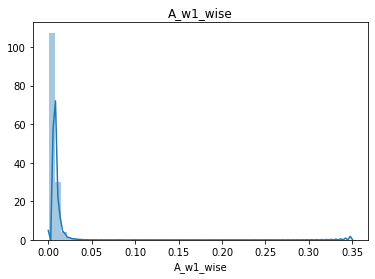

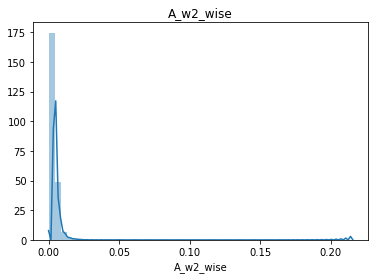

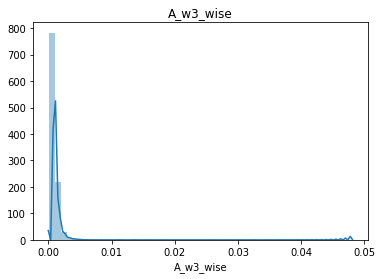

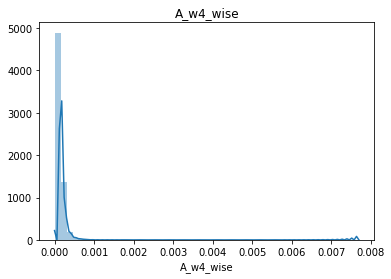

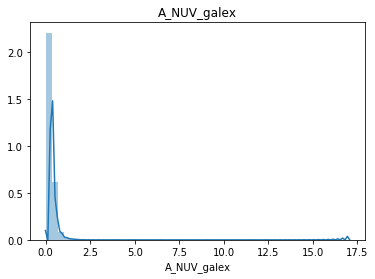

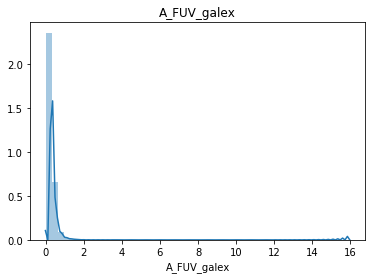

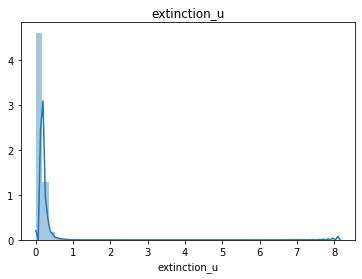

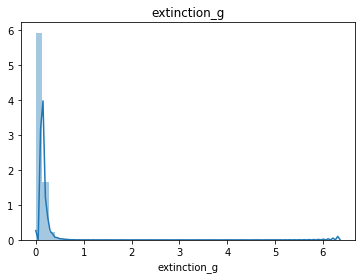

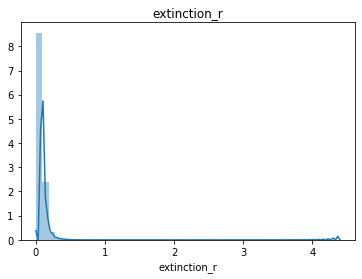

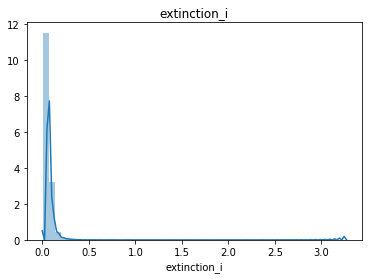

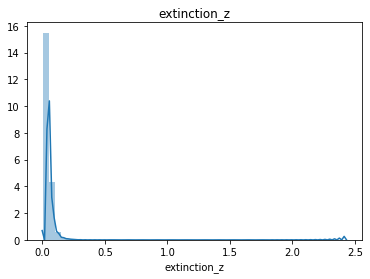

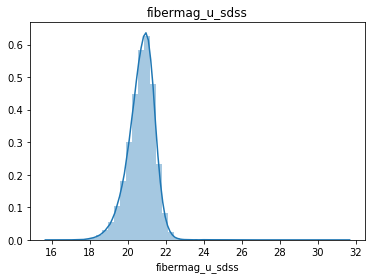

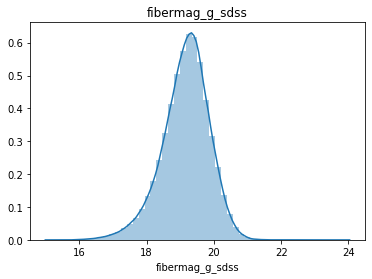

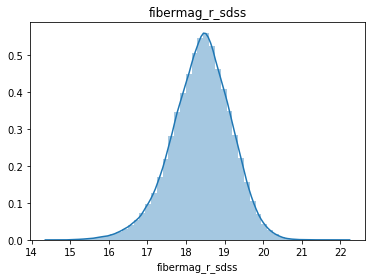

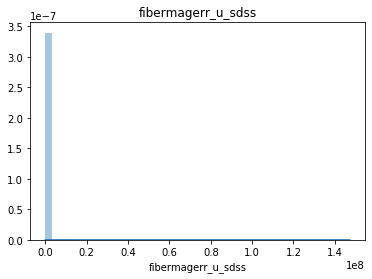

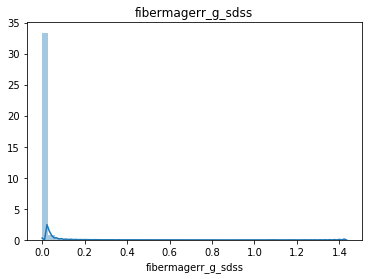

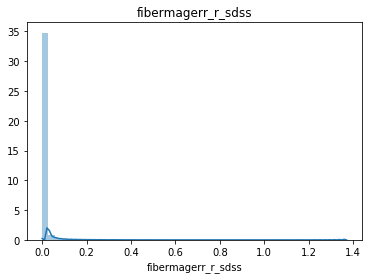

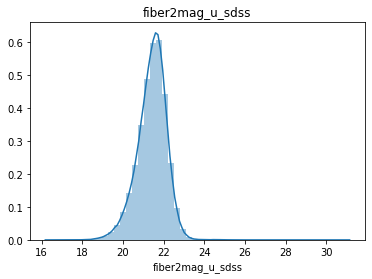

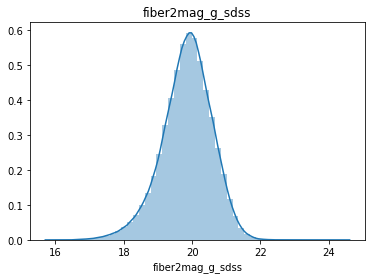

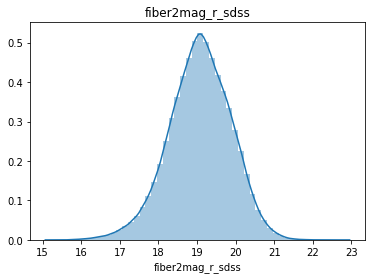

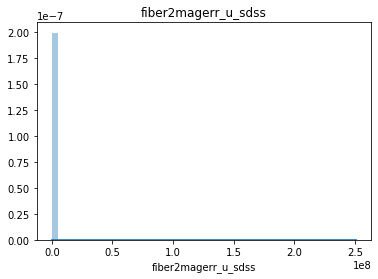

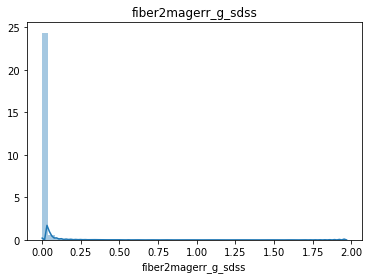

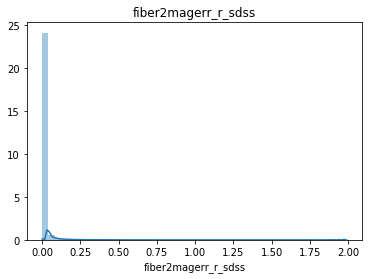

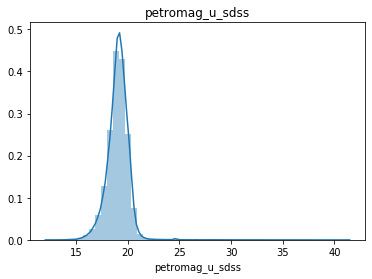

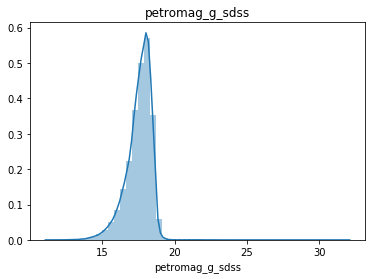

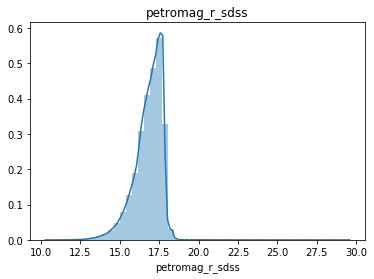

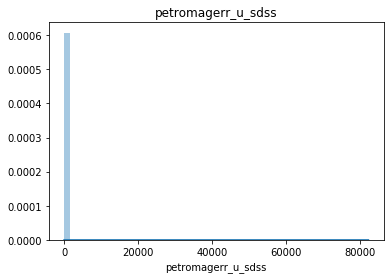

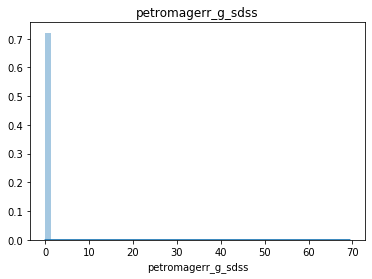

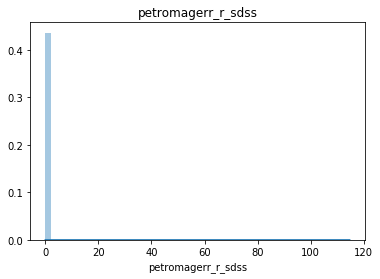

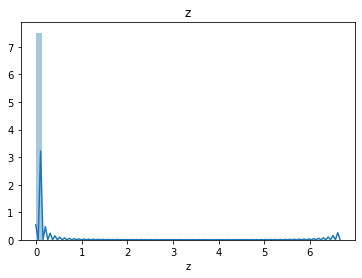

In [39]:
for c in x.columns:
    sns.distplot(x[c])
    plt.title(c)
    plt.show()